In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.1.0


In [ ]:
'''
1、 load datas
2、 preprocess
3、 tools
3.1、 generate position embedding
3.2、 creat mask (a. padding. b. decoder)
3.3、 scaled_dot_producte_attention
4、 build model
4.1、 Multi-Head Attention
4.2、 EncoderLayer
4.3、 DecoderLayer
4.4、 EncoderModel
4.5、 DecoderModel
4.6、 Transformer
5、 loss & optimizer
6、 train step
7、 Evaluate and Visualize
'''

In [4]:
import tensorflow_datasets as tfds

examples, info = tfds.load('ted_hrlr_translate/pt_to_en', 
                           with_info = True, 
                           as_supervised = True)
train_examples, val_examples = examples['train'], examples['validation']
print(info)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)



In [5]:
# 导入的数据已经是dataset，里面都是tensor
# .numpy() 后才是单词组成的句子
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'

b'mas e se estes fatores fossem ativos ?'
b'but what if it were active ?'

b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
b"but they did n't test for curiosity ."

b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
b'and this conscious defiance is why i , as an agnostic , can still have faith .'

b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
b'you can use everything on the table on me .'



In [6]:
# 转为sub_word数据集
# 从语料中构建sub_word词表的方法：build_from_corpus
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), 
    target_vocab_size = 2 ** 13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)

In [7]:
# 试用tokenizer
sample_string = 'Transformer is awesome'

# 单词 --> id
tokenized_string = en_tokenizer.encode(sample_string)
print("Tokenized string is {}".format(tokenized_string))

# id --> 单词
origin_string = en_tokenizer.decode(tokenized_string)
print("The original string is {}".format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    # decode 传入的需要是list
    # "{}"可以让我们看出空格在哪里
    print('{} --> "{}"'.format(token, en_tokenizer.decode([token])))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799]
The original string is Transformer is awesome
7915 --> "T"
1248 --> "ran"
7946 --> "s"
7194 --> "former "
13 --> "is "
2799 --> "awesome"


In [8]:
print(pt_tokenizer.vocab_size)
print(pt_tokenizer.decode([8214]))

8214


ValueError: Received id 8214 which is invalid. Ids must be within [0, 8214).

In [9]:
# 构建数据集
buffer_size = 20000
batch_size = 64
max_length = 40

def encode_to_subword(pt_sentence, en_sentence):
    # 需要给句子前后各加一个特殊字符
    # 开头 <start>id  结尾 <end>id
    # tokenizer里 id是  0 -> vocab_size -1
    # \ 后面不能加空格
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence

# 将低于max_length的数据样本过滤
# 返回布尔值
def filter_by_max_length(pt, en):
    # 处理的可能是tensor，所以用tf的API
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)

# 封装python函数
# 因为我们在调用dataset的map函数时不能够直接调用python函数
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [pt_sentence, en_sentence],
                          [tf.int64, tf.int64])

# 处理dataset
# map：train_examples里面的所有葡萄牙语和英语的句子转为subword的id
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
# ([-1], [-1]) 有两个维度，每个维度都扩展到最高的值
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes = ([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(filter_by_max_length)
valid_dataset = valid_dataset.padded_batch(batch_size, padded_shapes = ([-1], [-1]))

In [10]:
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 38) (64, 40)
(64, 39) (64, 35)
(64, 39) (64, 39)
(64, 39) (64, 39)
(64, 39) (64, 36)


In [11]:
# 3、tools
# 位置编码
# PE(pose, 2i) = sin(pos / 10000^(2i/d_model))
# PE(pose, 2i+1) = cos(pos / 10000^(2i/d_model))

def get_angles(pos, i, d_model):
    # pos: 词语在句子中的位置  shape = [sentence_length, 1]
    # i: 词语在embedding中的位置  shape = [1, d_model]
    # d_model: embedding的大小
    # result.shape = [sentence_legth, d_model]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def get_position_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                             np.arange(d_model)[np.newaxis, :],
                             d_model)
    # 取偶数位置 shape = [sentence_legth, d_model/2]
    sines = np.sin(angle_rads[:, 0::2])
    # 取奇数位  shape = [sentence_length, d_model/2]
    cosines = np.cos(angle_rads[:, 1::2])
    
    # shape = [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    # shape = [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]
    return tf.cast(position_embedding, dtype = tf.float32)

position_embedding = get_position_embedding(50, 512)
print(position_embedding.shape)

(1, 50, 512)


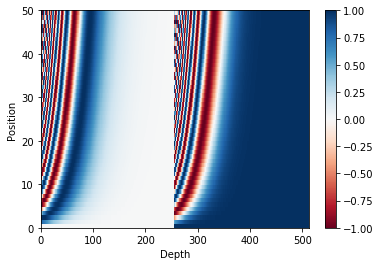

In [12]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap = 'RdBu')
    plt.xlabel("Depth")
    plt.ylabel("Position")
    plt.xlim(0, 512)
    plt.colorbar()
    plt.show()
plot_position_embedding(position_embedding)

In [13]:
# 生成mask
# 1、padding mask  self-attention也需要将padding mask掉

# batch_data.shape = [batch_size, seq_len]
def creat_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # shape = [batch_size, 1, 1, seq_len]
    # 为了与attention_weights更加方便计算
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
creat_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [14]:
'''
attention_weights.shape = [3, 3]
[[1, 2, 3],
 [4, 5, 6],
 [7, 8, 9]]
 aij: 第i个单词跟第j个单词的attention。若要达到第i个单词只与他之前的单词有关系，则：
[[1, 0, 0],
 [4, 5, 0],
 [7, 8, 9]]
 下三角矩阵，mask罩在矩阵主对角线之上
 矩阵中被mask的标记成1，不被mask标记成0
'''

def creat_look_ahead_mask(size):
    # lower_band = -1 --> 主对角线 下=1，上=0
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    # shape = (seq_len, seq_len)
    return mask

creat_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [15]:
# 缩放点积注意力
def scaled_dot_product_attention(q, k, v, mask):
    '''
    q.shape = (..., seq_len_q, depth)
    k.shape = (..., seq_len_q, depth)
    v.shape = (..., seq_len_v, depth_v)
    seq_len_k == seq_len_v
    q * k^T 后mask，mask.shape = (..., seq_len_q, seq_len_k)
    renturns:
        output : weighted sum
        attention_weights: 
    '''
    # transpose_b:转置第二个矩阵
    # 只对后两个维度做矩阵乘法
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    dk = tf.cast(tf.shape(k)[-1], dtype = tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        # logits会经过softmax，使得其softmax之后的值无限接近于0，达到mask效果
        scaled_attention_logits += (mask * -1e9)
        
    # attention_weights.shape = (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    
    # shape = (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention_weights:")
    print(temp_att)
    print("Output:")
    print(temp_out)
    
temp_k = tf.constant([[10, 0, 0], 
                      [0, 10, 0], 
                      [0, 0, 10], 
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)
temp_v = tf.constant([[1, 0], 
                      [10, 0], 
                      [100, 5], 
                      [1000, 6]], dtype = tf.float32)  # (4, 2)
temp_q1 = tf.constant([[0, 10, 0]], dtype = tf.float32) # (1, 3)
np.set_printoptions(suppress = True)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

temp_q2 = tf.constant([[0, 0, 10]], dtype = tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

temp_q3 = tf.constant([[10, 10, 0]], dtype = tf.float32)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0]], dtype = tf.float32)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention_weights:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Attention_weights:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
Attention_weights:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
Attention_weights:
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output:
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [16]:
# Multi-Head Attention
class MultiHeadAttention(keras.layers.Layer):
    '''
    理论中：同一个x
    x -> wq0 -> q0
    x -> wk0 -> k0
    x -> wv0 -> v0
    实践中：初始的值不一定是一样的
           slef-attention中q，k，v是一样的
           encoder和decoder的attention来说k和v是一样的，q不一样
    q -> wq0 -> q0 
      -> wq1 -> q1   实现技巧：
      ...                   q -> wq -> Q -> split -> q0, q1, q2,...
    k -> wk0 -> k0
      ...
    v -> wv0 -> v0
      ...
    得到的结果q0，q1，..，k0，...,v0,...再做多头注意力
    '''
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        # x.shape = (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, depth)
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # 重排列
        # 因为在saled_dot_product_attention函数中，是用后两个维度计算attention
        # 所以需要将num_heads先换到前面去，再换回来
        return tf.transpose(x, perm = [0, 2, 1, 3])
               
    def call(self, q, k, v, mask):
        # 取出batch_size
        batch_size = tf.shape(q)[0]
        # 让q,k,v分别经过全联接层
        # embedding  -> shape = (batch_size, seq_len, embedding_dim)
        # 中间层输出   -> shape = (batch_size, seq_dim, output_dim_last_step)
        q = self.WQ(q) # q.shape = (batch_size, seq_len_q, d_model)
        k = self.WK(k) # k.shape = (batch_size, seq_len_k, d_model)
        v = self.WV(v) # v.shape = (batch_size, seq_len_v, d_model)
        
        # shape = (batch_size, num_heads, seq_len_q(k,v), depth)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # scaled_attention_output.shape = (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        
        # 拼接 多头的信息存在第二维和第四维中，需要先2、3维换位置， 再拼接3、4维
        # shape = (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(scaled_attention_outputs,
                                                perm = [0, 2, 1, 3])
        # shape = (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs, 
                                      (batch_size, -1, self.d_model))
        
        # shape = (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        return output, attention_weights

temp_mha = MultiHeadAttention(d_model = 512, num_heads = 8)
y = tf.random.uniform((1, 60, 256)) # (batch_size, seq_len_q, dim)
output, attn = temp_mha(y, y, y, mask = None)
print(output.shape)
print(attn.shape)

(1, 60, 512)
(1, 8, 60, 60)


In [17]:
def feed_forward_network(d_model, dff):
    # dff: dim of feed_forward network
    return keras.Sequential([
        keras.layers.Dense(dff, activation = 'relu'),
        keras.layers.Dense(d_model)
    ])

sample_fnn = feed_forward_network(512, 2048)
sample_fnn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [18]:
# EncoderLayer
class EncoderLayer(keras.layers.Layer):
    '''
    block: + dropout
    x -> self_attention -> add & norm & dropout-> feed_forward -> add & norm & dropout
    '''
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        
    def call(self, x, training, encoder_padding_mask):
        # x.shape = (batch_size, seq_len, dim)
        # attn_output.shape = (batch_size, seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, encoder_padding_mask)
        # dropout在训练和和测试的时候反应是不一样的
        attn_output = self.dropout1(attn_output, training = training)
        # " + " 要求 dim = d_model 
        out1 = self.layer_norm1(x + attn_output)
        
        # ffn_output.shape = (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        out2 = self.layer_norm2(out1 + ffn_output)
        
        # decoder只一个输出
        return out2
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)


In [19]:
# 多一个Encoder和Decoder之间的MultiHeadAttention
# 多一个层次

class DecoderLayer(keras.layers.Layer):
    '''
    x -> self_attention -> add & norm & dropout -> out1
    out1 + encoding_outputs -> attention -> add & norm & dropout -> out2
    out2 -> ffn -> add & norm & dropout -> out3
    
    '''
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        # 初始化两个MultiHeadAttenion层
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)

        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def call(self, x, encoding_outputs, training, 
             decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask :look_ahead_mask logical_and deocder_padding_mask 
        # x.shape = (batch_size, target_seq_len, d_model_decoder)
        # encoding_outputs.shape = (batch_size, input_seq_len, d_model_encoder)
        # d_model_encoder = d_model_decoder
        
        # attn1, out1.shape = (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(x + attn1)
        
        # attn2, out2.shape = (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(out1, encoding_outputs, encoding_outputs, 
                                         encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layer_norm2(out1 + attn2)
        
        # ffn_output, out3 = (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training = training)
        out3 = self.layer_norm3(out2 + ffn_output)
        
        return out3, attn_weights1, attn_weights2
    
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_aw1, sample_decoder_aw2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)
print(sample_decoder_output.shape)
print(sample_decoder_aw1.shape)
print(sample_decoder_aw2.shape)

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


In [24]:
# 建立EncoderModel
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate = 0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
    
        self.embedding = keras.layers.Embedding(input_vocab_size, self.d_model)
    
        # position_embedding.shape = (1, max_lengthm d_model)
        self.position_embedding = get_position_embedding(max_length, self.d_model)
    
    
        # 在获得的embedding上做dropout
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                                for _ in range(self.num_layers)]
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape = (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        
        # 验证输入
        # error
        # assert input_seq_len <= self.max_length
        tf.debugging.assert_less_equal(input_seq_len, self.max_length,
                            "input_seq_len should be less or equal to self.max_length")
        
        # x.shape = (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        # 做这个缩放的原因是：
        # x默认embedding初始化的时候是在【0，1】的均匀分布取到的
        # 缩放后x属于【0，d_model】
        # 是的缩放后的x加上position_embedding x本身起的作用会比较大一些
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # x_len 可能 < max_len, 所以切片 而第一个维度会被复制 1 --> batch_size
        x += self.position_embedding[:, input_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training, encoder_padding_mask)
            
        # x.shape = (batch_size, input_seq_len, d_model)
        return x    
    
sample_encoder_model = EncoderModel(2, 8500, max_length, 512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(sample_encoder_model_input, 
                                                   False, encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


In [31]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length, 
                 d_model, num_heads, dff, rate = 0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
        self.position_embedding = get_position_embedding(max_length, d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                               for _ in range(self.num_layers)]
    
    def call(self, x, encoding_outputs, training, 
             decoder_mask, encoder_decoder_padding_mask):
        # x.shape = (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        # assert output_seq_len <= self.max_length
        # 报错：tensor不能用布尔值
        tf.debugging.assert_less_equal(output_seq_len, self.max_length,
                             "output_seq_len should be less or equal self.max_length")
        
        
        attention_weights = {}
        
        # x.shape = (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x, attn1, attn2 = self.decoder_layers[i](x, encoding_outputs, training, 
                                                     decoder_mask, 
                                                     encoder_decoder_padding_mask)
            attention_weights['decoder_layer{}_attn1'.format(i + 1)] = attn1
            attention_weights['decoder_layer{}_attn2'.format(i + 1)] = attn2
        # x.shape = (batch_size, output_seq_len, d_model)
        return x, attention_weights

sample_decoder_model = DecoderModel(2, 8000, max_length, 512, 8, 2048)
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_attn = sample_decoder_model(
    sample_decoder_model_input, 
    sample_encoder_model_output, 
    training = False, decoder_mask = None, encoder_decoder_padding_mask = None)
print(sample_decoder_model_output.shape)
for key in sample_decoder_model_attn:
    print(sample_decoder_model_attn[key].shape)

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [34]:
# 形成Transformer
# 最后一个大model继承keras.Model
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate = 0.1):
        super(Transformer, self).__init__()
        self.encoder_model = EncoderModel(num_layers, input_vocab_size, max_length,
                                          d_model, num_heads, dff, rate)
        self.decoder_model = DecoderModel(num_layers, target_vocab_size, max_length,
                                          d_model, num_heads, dff, rate)
        
        # 接受docoder_layer的输出，再映射到词表大小的空间中去
        self.final_layer = keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, encoder_padding_mask, 
             decoder_mask, encoder_decoder_padding_mask):
        # shape = (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(inp, training, encoder_padding_mask)
        
        # shape = (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(tar, encoding_outputs,
                                                                 training, 
                                                                 decoder_mask,
                                                                 encoder_decoder_padding_mask)
        # shape = (batch_size, outout_seq_len, traget_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights
    
sample_transformer = Transformer(2, 8500, 8000, max_length, 512, 8, 2048, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sample_transformer(temp_input, temp_target,
                                                    training = False,
                                                    encoder_padding_mask = None,
                                                    decoder_mask = None,
                                                    encoder_decoder_padding_mask = None)
print(predictions.shape)
for key in attention_weights:
    print(attention_weights[key].shape)

(64, 31, 8000)
(64, 8, 31, 31)
(64, 8, 31, 26)
(64, 8, 31, 31)
(64, 8, 31, 26)


In [35]:
# 模型训练
# 1、initializes model
# 2、define loss optimizer, learning_rate schedule
# 3、train_step 单步训练
# 4、包装train_step  train_process 

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)


In [40]:
# paper: lrate = (d_model ** (-0.5) * min(step_num ** (-0.5), 
#                                     step_num * warm_up_steps ** (-1.5))

class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    # 注意这里的函数名！！
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1, arg2)

# 模型（d_model）越大，arg3越小，learning_rate越小
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate, 
                                  beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)


Text(0, 0.5, 'Learning rate')

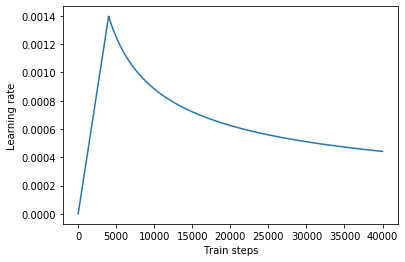

In [41]:
# learning_rate 可视化
temp_lrs = CustomizedSchedule(d_model)
plt.plot(temp_lrs(tf.range(40000, dtype = tf.float32)))
plt.xlabel("Train steps")
plt.ylabel("Learning rate")

In [42]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits = True, 
                                                         reduction = 'none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [45]:
# 根据需要创建mask
def creat_masks(inp, tar):
    '''
    需要的masks：
      - encoder_padding_mask (self_attention of EncoderLayer)
      - decoder_look_ahead_mask (self_attenion of DecoderLayer)
      - decoder_padding_mask  (self_attention of DecoderLayer) 
      # 一个attention两个mask 与操作
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
    '''
    
    encoder_padding_mask = creat_padding_mask(inp)
    encoder_decoder_padding_mask = creat_padding_mask(inp)
    
    look_ahead_mask = creat_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = creat_padding_mask(tar)
    # 合并 被mask的为1，不被mask的为0
    # 与操作与取最大值操作等价
    decoder_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)
    
    print(encoder_padding_mask.shape)
    print(encoder_decoder_padding_mask.shape)
    print(look_ahead_mask.shape)      # (39, 39)       --> (64, 1, 39, 39)
    print(decoder_padding_mask.shape) # (64, 1, 1, 39) --> (64, 1, 39, 39)
    print(decoder_mask.shape)         # (64, 1, 39, 39)
    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

temp_inp, temp_tar = iter(train_dataset.take(1)).next()
print(temp_inp.shape, temp_tar.shape)
creat_masks(temp_inp, temp_tar)

(64, 36) (64, 40)
(64, 1, 1, 36)
(64, 1, 1, 36)
(40, 40)
(64, 1, 1, 40)
(64, 1, 40, 40)


(<tf.Tensor: shape=(64, 1, 1, 36), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 40, 40), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 遍历数据集时的累记指标 并不是最终的指标参数
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = creat_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, encoder_padding_mask,
                                     decoder_mask, encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    
epochs = 10
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch & 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch + 1,batch, train_loss.result(), train_accuracy.result()))
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuray.result()))
    print('Time for 1 epoch: {} seconds\n'.format(time.time() - start))
    

In [ ]:
# evaluate
'''
A, B, C, D -> E
A, B, C, D, E -> F
A, B, C, D, E, F -> G
'''

def evaluate(inp_sentence):
    input_id_sentence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    
    # shape = (1, input_sentence_len)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # shape = (1, 1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        endoer_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = creat_masks(encoder_input, decoder_input)
        
        # pred.shape = (batch_size, output_target_len, target_vocab_size)
        # output_target_len 就是decoder_input当前的长度
        # 对于decoder_input中每一个值都会给出一个预测
        # 但我们只需要最有一次的预测值， 即decoder_input全部输入进去后的预测值
        predictions, attention_weights = transformer(encoder_input, decoder_input, 
                                                     False, encoder_padding_mask,
                                                     decoder_mask,
                                                     encoder_decoder_padding_mask)
        # 切分，取出最后一个预测值
        # shape = (batch_size, target_vocab_size)
        predictions = predictions[:, -1, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)
        
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            # decoder_input.shape = (1, target_len) 第一个维度没有用
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        # 如果直接[decoder_input, predicted_id] 维度错误
        decoder_input = tf.concat([decoder_input, [predicted_id]], axis = -1)
        
    return tf.squeeze(decoder_input, axis = 0), attention_weights

In [ ]:
def plot_encoder_decoder_attention(attention, input_sentence, result, layer_name):
    # layer_name: key in attention_weights
    fig = plt.figure(figsize = (16, 8))
    
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    # attetion[layer_name].shape = (batch_size, num_heads, tar_len, input_len)
    # evaluate每次都只处理一个样本，batch_size = 1，消掉第一个维度
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        
        # predicted_id 没有加上end_id，二者相等的时候就直接返回了
        # 只有0到倒数第二个值会被放在attention矩阵中
        ax.matshow(attention[head][:-1, :])
        
        fontdict = {'fontsize': 10}
        
        # 将input_sentence和result中对应的单词画到图中去，所以需要让图知道需要多少个锚点
        # 每个锚点绘制一个单词  
        # + 2有一个start_id, end_id
        # range: 将长度转换成列表
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result) - 1.5, -0.5)
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] \
            + ['<end>'],fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
        plt.tight_layout()
        plt.show()

In [ ]:
def translate(input_sentence, layer_name = ''):
    result_id, attention_weights = evaluate(input_sentence)
    
    # if的作用：1、不想decode start_id和end_id  2、超出id范围，decode会出错
    predicted_sentence = en_tokenizer.decode(
        [i for i in result_id if i < en_tokenizer.vocab_size])
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence, 
                                       result_id, layer_name)

In [ ]:
translate("", layer_name = 'decoder_layer4_attn2')